# This is a grey world.

The goal of this project is to creat colored pictures out of thrre grey pictures, took in RGB. The input data is one picture, made with the 3 grey pictures. The problem will consist on finding how to align the 3 pictures.

#### Disclaimer

Since I never used opencv, I googled some tutorials, and added keywords to find parts of the libraries that could be usefull in image fusion. By doing this, I found a tutorial explaining how to find the homography between two images of the same object, taken from two different positions. So I used the same functions (or some close to the one used), without looking at the code, but this was, of course, a huge help. The link of this tutorial is: 

https://www.learnopencv.com/image-alignment-feature-based-using-opencv-c-python/

## Explanation

The method I will use is based on mathing points in both images. Basically, In the first method, we do the same thing but considering the point we want to match is the whole image. 

In this second method, we will use an opencv function to find mathing points in two images (red and blue for instance), compare those points with each-other and rank them by how well they match.

After that, we will be able to get the homography between those two images (we consider that the green image, for instance, is an homography of the blue one).

With the homography, we can then transform the second image so it's matching points are at the same position as those in the first picture. 

This method has an overkill complexity, since it handles rotations and "point of view" movement, but it works.

## Separate the picture in 3.

Again, the first task is to cut the input picture and to cut in in 3 pictures. This part is common for both methods.

In [1]:
import cv2
import numpy
from matplotlib import pyplot as plt

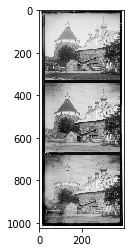

In [2]:
im = cv2.imread("01.png")
im_grey = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)

plt.imshow(im_grey, cmap='gray')
plt.show()

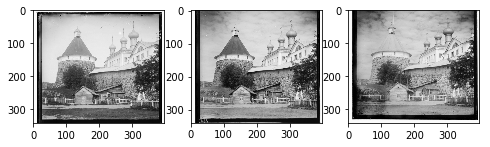

In [3]:
height, width = im_grey.shape
im_red = im_grey[0:height//3, : ]
im_green = im_grey[height//3+1 : 2*(height//3), : ]
im_blue = im_grey[2*(height//3)+1:, : ]

rows = 1
columns = 3
fig = plt.figure(figsize = (8,8))
fig.add_subplot(rows, columns, 1)
plt.imshow(im_red, cmap='gray')
fig.add_subplot(rows, columns, 2)
plt.imshow(im_green, cmap='gray')
fig.add_subplot(rows, columns, 3)
plt.imshow(im_blue, cmap='gray')

plt.show()

## Finding the interest points.

To find interest points, I used the ORB (Oriented FAST and Rotated BRIEF) function. Link of the documentation :

https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_orb/py_orb.html

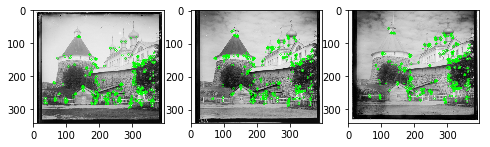

In [4]:
MAX_FEATURES = 500

orb = cv2.ORB_create(MAX_FEATURES)

keypoints_blue = orb.detect(im_blue, None)
keypoints_green = orb.detect(im_green, None)
keypoints_red = orb.detect(im_red, None)

keypoints_blue, des_blue = orb.compute(im_blue, keypoints_blue)
keypoints_red, des_red = orb.compute(im_red, keypoints_red)
keypoints_green, des_green = orb.compute(im_green, keypoints_green)


im_b_2 = cv2.drawKeypoints(im_blue, keypoints_blue, outImage = None, color=(0,255,0), flags=0)
im_r_2 = cv2.drawKeypoints(im_red, keypoints_red, outImage = None, color=(0,255,0), flags=0)
im_g_2 = cv2.drawKeypoints(im_green, keypoints_green, outImage = None, color=(0,255,0), flags=0)

rows = 1
columns = 3
fig = plt.figure(figsize = (8,8))
fig.add_subplot(rows, columns, 1)
plt.imshow(im_r_2)
fig.add_subplot(rows, columns, 2)
plt.imshow(im_g_2)
fig.add_subplot(rows, columns, 3)
plt.imshow(im_b_2)

plt.show()

## Matching the interest points.

We rank the pairs of points by how well they match. We will then use the best pairs to find the homography. To do this, I found this documentation :

https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_matcher/py_matcher.html

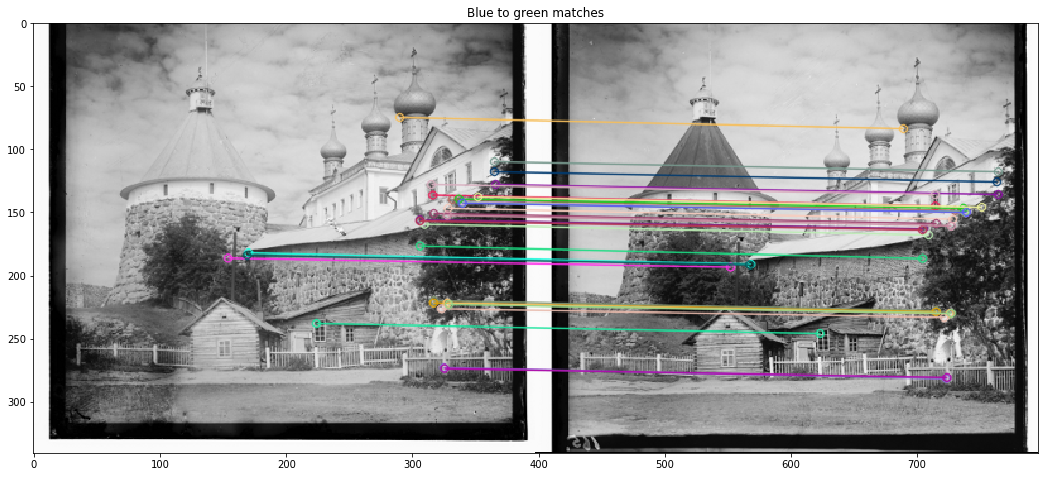

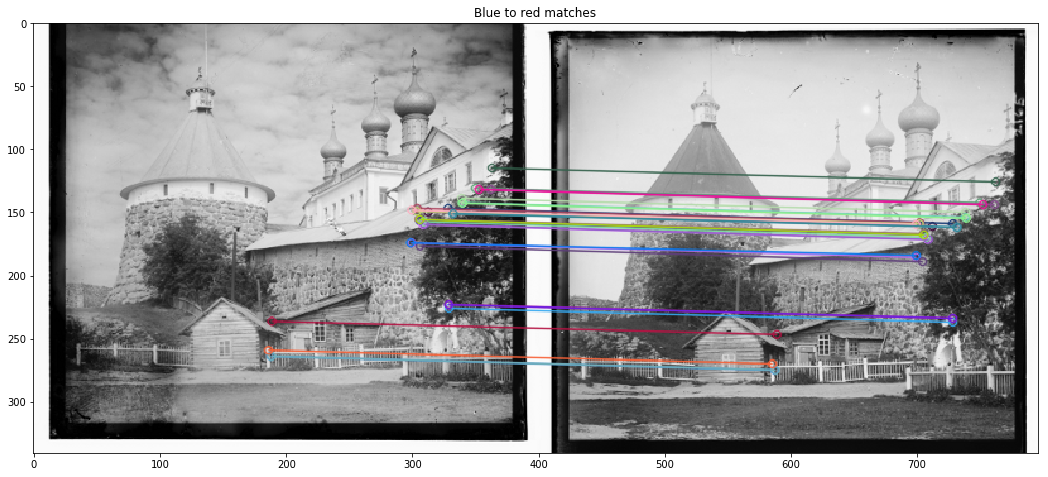

In [5]:
matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

matches_b_g = matcher.match(des_blue, des_green)
matches_b_r = matcher.match(des_blue, des_red)

matches_b_g = sorted(matches_b_g, key = lambda x:x.distance)
matches_b_r = sorted(matches_b_r, key = lambda x:x.distance)

# In the introduction of the tutorial, it is said that 4 mathing points is enough to find the homography. 

matches_b_g = matches_b_g[0:30]
matches_b_r = matches_b_r[0:30]

img_b_g = cv2.drawMatches(im_blue, keypoints_blue, im_green, keypoints_green, matches_b_g, flags=2, outImg = None)
img_b_r = cv2.drawMatches(im_blue, keypoints_blue, im_red, keypoints_red, matches_b_r, flags=2, outImg = None)

fig = plt.figure(figsize = (18,18))
plt.imshow(img_b_g)
plt.title("Blue to green matches", )
plt.show()

fig = plt.figure(figsize = (18,18))
plt.imshow(img_b_r)
plt.title("Blue to red matches", )
plt.show()


## Getting localisation of those points and finding homography

To extract the positions, see this discussion in stack overflow :

https://stackoverflow.com/questions/30716610/how-to-get-pixel-coordinates-from-feature-matching-in-opencv-python

In [6]:
list_keypoints_b_br = []
list_keypoints_r_br = []

for mat in matches_b_r:

    img_b_idx = mat.queryIdx
    img_r_idx = mat.trainIdx

    (x1,y1) = keypoints_blue[img_b_idx].pt
    (x2,y2) = keypoints_red[img_r_idx].pt

    list_keypoints_b_br.append((x1, y1))
    list_keypoints_r_br.append((x2, y2))


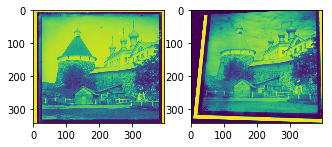

In [7]:
# find homography

list_keypoints_b_br = numpy.asarray(list_keypoints_b_br, dtype = numpy.float32)
list_keypoints_r_br = numpy.asarray(list_keypoints_r_br, dtype = numpy.float32)

h_br, mask = cv2.findHomography(list_keypoints_r_br, list_keypoints_b_br, cv2.RANSAC)

# transform red image to match blue one

height, width = im_blue.shape
transformed_im_r = cv2.warpPerspective(im_blue, h_br, (width, height))

rows = 1
columns = 3
fig = plt.figure(figsize = (8,8))
fig.add_subplot(rows, columns, 1)
plt.imshow(im_red)
fig.add_subplot(rows, columns, 2)
plt.imshow(transformed_im_r)
#fig.add_subplot(rows, columns, 3)
#plt.imshow(im_b_2)

## Affine transformation

As be can see above, it isn't working very well. To me, the main issu is that the best matching points are on the same line, giving the "perpective change" factor too much importance. Therefore, I will try to use affine transformation.

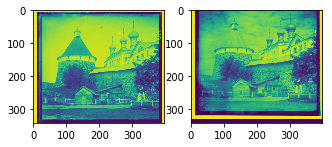

In [8]:
list_keypoints_b_br = []
list_keypoints_r_br = []

for mat in matches_b_r:

    img_b_idx = mat.queryIdx
    img_r_idx = mat.trainIdx

    (x1,y1) = keypoints_blue[img_b_idx].pt
    (x2,y2) = keypoints_red[img_r_idx].pt

    list_keypoints_b_br.append((x1, y1))
    list_keypoints_r_br.append((x2, y2))

# to avoid the previous problem, we will take the 3 points which maximise the area of the triangle.

def get_best_triangle(L):
    best_area = 0
    best_points = []
    for i in range(0, len(L)-2):
        for j in range(i+1, len(L)-1):
            for k in range(j+1, len(L)):
                a = ((L[i][0]-L[j][0])**2 + (L[i][1]-L[j][1])**2)**0.5
                b = ((L[i][0]-L[k][0])**2 + (L[i][1]-L[k][1])**2)**0.5
                c = ((L[j][0]-L[k][0])**2 + (L[j][1]-L[k][1])**2)**0.5
                s = (a + b + c) / 2
                area = (s*(s-a)*(s-b)*(s-c)) ** 0.5
                if area > best_area:
                    best_points = [i, j, k]
    return(best_points)

best_points = get_best_triangle(list_keypoints_b_br)

list_keypoints_b_br = [list_keypoints_b_br[best_points[0]], list_keypoints_b_br[best_points[1]], list_keypoints_b_br[best_points[2]]]
list_keypoints_r_br = [list_keypoints_r_br[best_points[0]], list_keypoints_r_br[best_points[1]], list_keypoints_r_br[best_points[2]]]



list_keypoints_b_br = numpy.asarray(list_keypoints_b_br, dtype = numpy.float32)
list_keypoints_r_br = numpy.asarray(list_keypoints_r_br, dtype = numpy.float32)


h_br = cv2.getAffineTransform(list_keypoints_r_br[:3], list_keypoints_b_br[:3])

height, width = im_blue.shape
transformed_im_r = cv2.warpAffine(im_blue, h_br, (width, height))

rows = 1
columns = 3
fig = plt.figure(figsize = (8,8))
fig.add_subplot(rows, columns, 1)
plt.imshow(im_red)
fig.add_subplot(rows, columns, 2)
plt.imshow(transformed_im_r)
#fig.add_subplot(rows, columns, 3)
#plt.imshow(im_b_2)

## Homemade method

Results with affine transformation are better, but not as good as what we could expect. Therefore, I'll try my own method : 

- select some of the best points
- find the best translation (no function found)
- apply translation

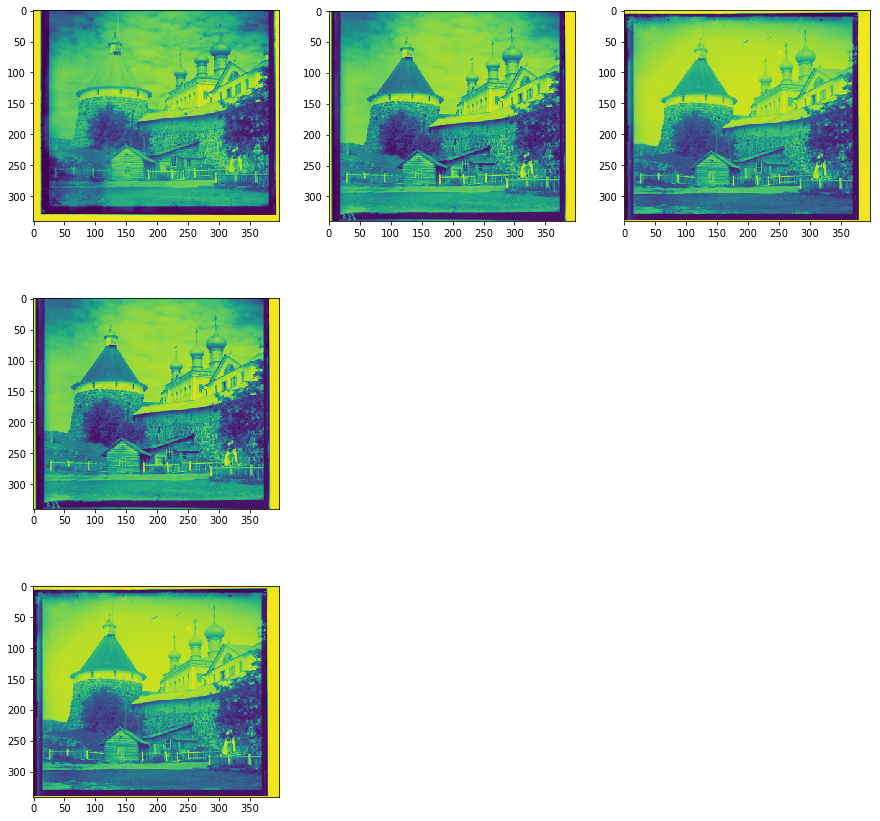

In [9]:
list_keypoints_b_br = []
list_keypoints_r_br = []

for mat in matches_b_r:

    img_b_idx = mat.queryIdx
    img_r_idx = mat.trainIdx

    (x1,y1) = keypoints_blue[img_b_idx].pt
    (x2,y2) = keypoints_red[img_r_idx].pt

    list_keypoints_b_br.append((x1, y1))
    list_keypoints_r_br.append((x2, y2))
    
list_keypoints_b_bg = []
list_keypoints_g_bg = []

for mat in matches_b_g:

    img_b_idx = mat.queryIdx
    img_g_idx = mat.trainIdx

    (x1,y1) = keypoints_blue[img_b_idx].pt
    (x2,y2) = keypoints_green[img_g_idx].pt

    list_keypoints_b_bg.append((x1, y1))
    list_keypoints_g_bg.append((x2, y2))

def find_offset(L1, L2, numb = 5):
    x_offset = 0
    y_offset = 0
    for i in range(0, numb):
        x_offset += L1[i][0] - L2[i][0]
        y_offset += L1[i][1] - L2[i][1]
    return(x_offset/numb, y_offset/numb)

x_off_r, y_off_r = find_offset(list_keypoints_b_br, list_keypoints_r_br, numb = 15)
x_off_g, y_off_g = find_offset(list_keypoints_b_bg, list_keypoints_g_bg, numb = 15)

def reshape(image, x_offset, y_offset):
    res = image.copy()
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            res[i, j] = image[(i + x_offset) % image.shape[0], (j + y_offset) % image.shape[1]]
    return(res)




rows = 3
columns = 3
fig = plt.figure(figsize = (15,15))
fig.add_subplot(rows, columns, 1)
plt.imshow(im_blue)
fig.add_subplot(rows, columns, 2)
plt.imshow(reshape(im_green, int(- x_off_g), int(- y_off_g)))
fig.add_subplot(rows, columns, 3)
plt.imshow(reshape(im_red, int(- x_off_r), int(- y_off_r)))
fig.add_subplot(rows, columns, 4)
plt.imshow(reshape(im_green, int(- x_off_g), int(- y_off_g)))
fig.add_subplot(rows, columns, 7)
plt.imshow(reshape(im_red, int(- x_off_r), int(- y_off_r)))

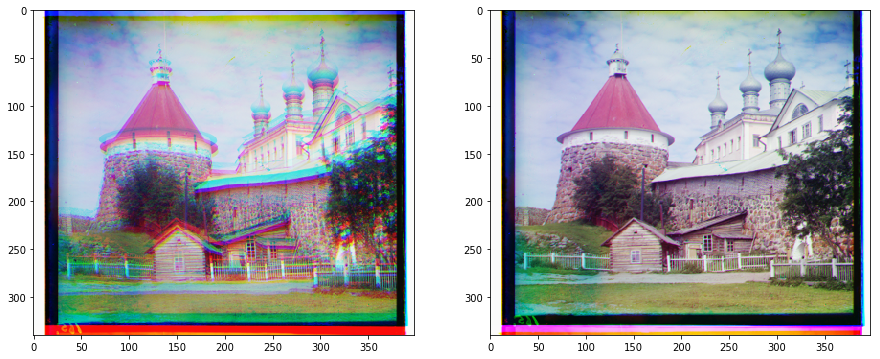

In [10]:
# now let's try the fusion.

im_red_reshaped = reshape(im_red, int(- y_off_r), int(- x_off_r))
im_green_reshaped = reshape(im_green, int(- y_off_g), int(- x_off_g))

def fuse_images(red, blue, green):
    good_h = min(red.shape[0], blue.shape[0], green.shape[0])
    good_w = min(red.shape[1], blue.shape[1], green.shape[1])
    red, blue, green = red[:good_h, :good_w], blue[:good_h, :good_w], green[:good_h, :good_w]
    im_colour = [[[blue[i][j], green[i][j], red[i][j]] for j in range(good_w)] 
             for i in range(good_h)]
    return(im_colour)

rows = 1
columns = 2
fig = plt.figure(figsize = (15,15))
fig.add_subplot(rows, columns, 1)
plt.imshow(fuse_images(im_red, im_blue, im_green))
fig.add_subplot(rows, columns, 2)
plt.imshow(fuse_images(im_red_reshaped, im_blue, im_green_reshaped))

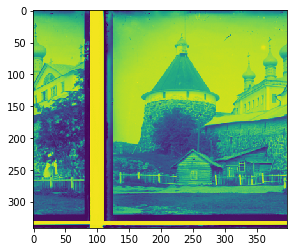

(<matplotlib.image.AxesImage at 0x259de1728d0>, None)

In [19]:
import numpy as np
plt.imshow(np.roll(im_red_reshaped,(100),axis=1)),plt.show()